In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   # Mean & std for MNIST
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)     # input 1x28x28 -> output 6x24x24
        self.pool = nn.AvgPool2d(2, 2)      # output 6x12x12
        self.conv2 = nn.Conv2d(6, 16, 5)    # output 16x8x8
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# =========================================
# 4. Training Setup
# =========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses, test_accuracies = [], []

In [9]:
# =========================================
# 5. Before Training (Baseline Evaluation)
# =========================================
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

print("Before training, test accuracy:", evaluate(model, test_loader))

Before training, test accuracy: 10.32


In [ ]:
# =========================================
# 6. Train Model
# =========================================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Epoch [1/5] - Loss: 0.2759 | Test Accuracy: 96.94%
Epoch [2/5] - Loss: 0.0851 | Test Accuracy: 98.36%
Epoch [3/5] - Loss: 0.0638 | Test Accuracy: 98.33%
Epoch [4/5] - Loss: 0.0509 | Test Accuracy: 98.69%
Epoch [5/5] - Loss: 0.0422 | Test Accuracy: 98.78%


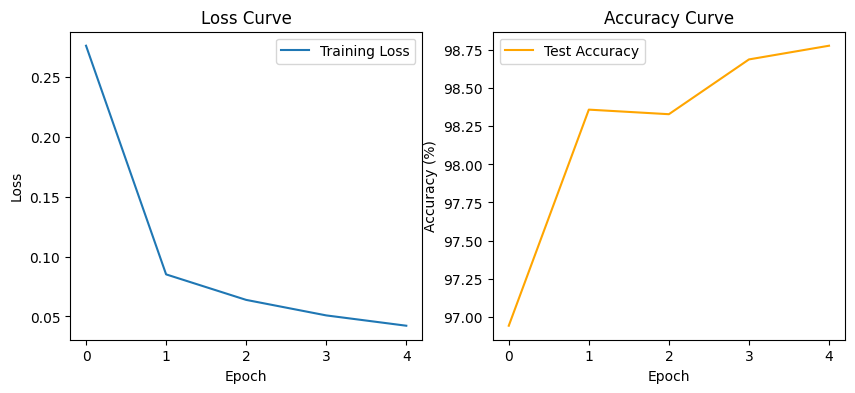

Final Test Accuracy: 98.78


In [11]:
# =========================================
# 7. Visualization
# =========================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# =========================================
# 8. Final Evaluation
# =========================================
final_acc = evaluate(model, test_loader)
print("Final Test Accuracy:", final_acc)